# 训练

In [2]:
# ./scripts/mmdet_train.sh retinanet

# 变量定义

In [2]:
import glob
import os

# 参数
model_name = 'retinanet'
model_stru = ''
model_cfg = ''
exp_name = f'{model_name}{model_stru}{model_cfg}'

# 路径
cfg_path = f'cfg/mmdet/{model_name}.py'
best_model_path = f'runs/mmdetection/{exp_name}/train/'
exp_id = max([f for f in os.listdir(best_model_path) if os.path.isdir(os.path.join(best_model_path, f))])  # 最新实验
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmdetection/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='retinanet'
best_model_path='runs/mmdetection/retinanet/train/best_coco_bbox_mAP_epoch_214.pth'
train_log_path='runs/mmdetection/retinanet/train/20231213_150310/vis_data/scalars.json'


# 日志分析

['lr', 'data_time', 'loss', 'loss_cls', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (214)0.922


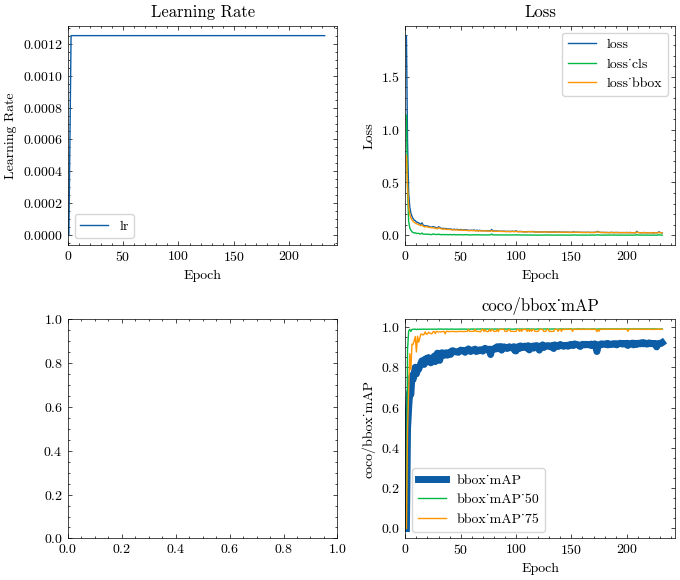

In [3]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmdet_retinanet_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmdet_retinanet_train_log(df_train, df_val, exp_name=exp_name)

# 测试

In [4]:
! scripts/mmdet_test.sh {cfg_path} {best_model_path} {exp_name}

12/13 23:59:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0,1,2,3,4,5,6,7,8,9: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_

# 评估

In [5]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmdetection/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.92s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.43s).
Accumulating evaluation results...
DONE (t=1.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.714
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.659,0.593,0.331
"AP (IoU=0.50, area=all, maxDets=100)",0.968,0.854,0.601
"AP (IoU=0.75, area=all, maxDets=100)",0.767,0.678,0.319
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.194,0.111
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.556,0.496,0.228
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.714,0.789,0.435
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.738,0.649,0.377
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.739,0.652,0.381
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.740,0.654,0.384
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.236,0.150


test_synth


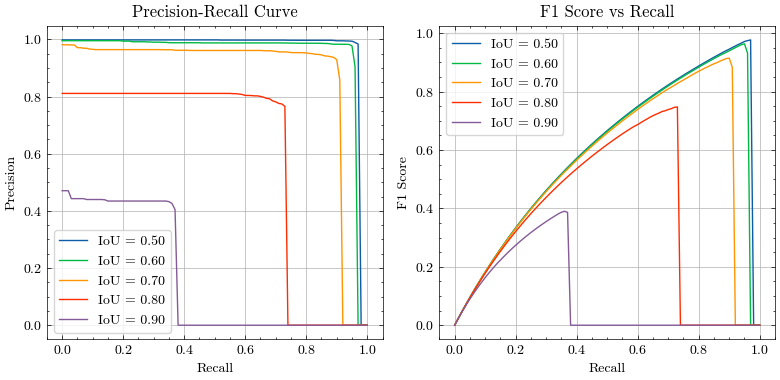

test_real_nominal


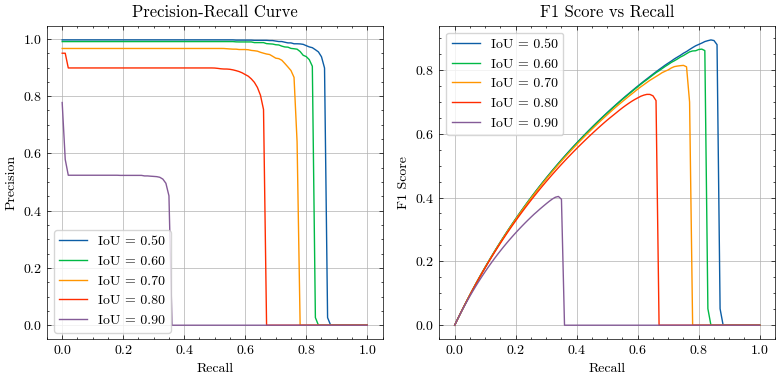

test_real_edge


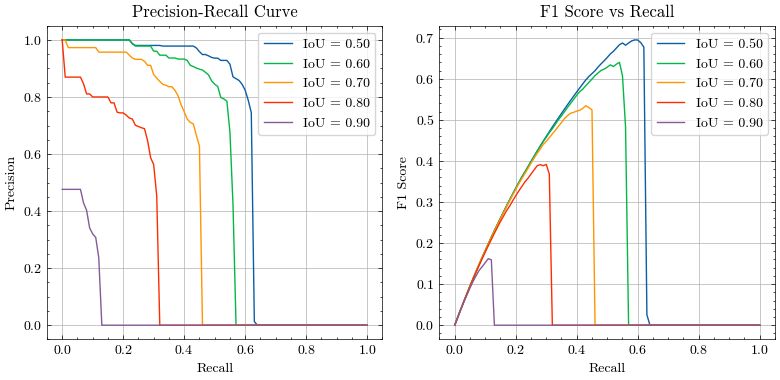

In [6]:
from src.utils.plot import plot_pr_curve

plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 测速

In [7]:
! scripts/mmdet_speed.sh {cfg_path} {best_model_path}

12/14 00:35:32 - mmengine - INFO - before build: 
12/14 00:35:32 - mmengine - INFO - (GB) mem_used: 4.60 | uss: 0.40 | pss: 0.42 | total_proc: 1
Loads checkpoint by local backend from path: runs/mmdetection/retinanet/train/best_coco_bbox_mAP_epoch_214.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
12/14 00:35:33 - mmengine - INFO - after build: 
12/14 00:35:33 - mmengine - INFO - (GB) mem_used: 4.91 | uss: 0.74 | pss: 0.76 | total_proc: 1
12/14 00:36:10 - mmengine - INFO - ==================================
12/14 00:36:11 - mmengine - INFO - Done image [500/2000], fps: 37.7 img/s, times per image: 26.5 ms/img, cuda memory: 373 MB
12/14 00:36:11 - mmengine - INFO - (GB) mem_used: 5.79 | uss: 1.88 | pss: 1.90 | total_proc: 1
12/14 00:36:46 - mmengine - INFO - ==================================
12/14 00:36:46 - mmengine - INFO - Done image [1000/2000], fps: 37.8 img/s, times per image: 26.5 ms/img, cuda memory: 373 MB
12/14 00:36:46 - mmengine - INF

In [14]:
# 12/14 00:37:57 - mmengine - INFO - ============== Done ==================
# 12/14 00:37:57 - mmengine - INFO - Overall fps: 37.8 img/s, times per image: 26.5 ms/img

# 12/14 00:40:45 - mmengine - INFO - ============== Done ==================
# 12/14 00:40:45 - mmengine - INFO - Overall fps: 32.2 img/s, times per image: 31.1 ms/img

# 12/14 00:41:24 - mmengine - INFO - ============== Done ==================
# 12/14 00:41:24 - mmengine - INFO - Overall fps: 32.4 img/s, times per image: 30.9 ms/img

In [8]:
# 保存结果
all_speed = {
    'test_synth': [26.5, 37.8],  # [average_time, fps]
    'test_real_nominal': [31.1, 32.2],
    'test_real_edge': [30.9, 32.4]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(
    f'results/tables/metrics/metrics_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [10]:
# from src.utils.database import write_detections_2_database
# write_detections_2_database(lib_type='mmdetection', exp_name=exp_name)


In [9]:
# from src.utils.database import delete_detections_from_database
# delete_detections_from_database(exp_name=exp_name)
